In [66]:
#homework 3

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

1. Modeling Volatility and VaR

In [68]:
df = pd.read_excel('../data/spy_data.xlsx', sheet_name='total returns', index_col='date')
df.index = pd.to_datetime(df.index)
df['Excess Returns'] = df['SPY'] - df['^IRX']
df

,SPY,^IRX,Excess Returns
date,,,
1994-01-04,0.004035,0.000122,0.003913
1994-01-05,0.002009,0.000122,0.001888
1994-01-06,0.000000,0.000121,-0.000121
1994-01-07,0.006016,0.000119,0.005897
1994-01-10,0.011960,0.000119,0.011841
...,...,...,...
2024-07-29,0.000588,0.000204,0.000384
2024-07-30,-0.005066,0.000204,-0.005270
2024-07-31,0.016255,0.000204,0.016051


1.1 Historic VaR

In [69]:
df = df[df.index >= '2000-12-29'].copy()

def calc_var(series):
    return series.quantile(.05)

df['VaR'] = df['Excess Returns'].expanding().apply(calc_var, raw=False)
df.head()

,SPY,^IRX,Excess Returns,VaR
date,,,,
2000-12-29,-0.018929,0.000227,-0.019157,-0.019157
2001-01-02,-0.018104,0.000225,-0.018329,-0.019115
2001-01-03,0.048035,0.000219,0.047815,-0.019074
2001-01-04,-0.010764,0.000208,-0.010972,-0.019033
2001-01-05,-0.032643,0.000197,-0.032840,-0.030103


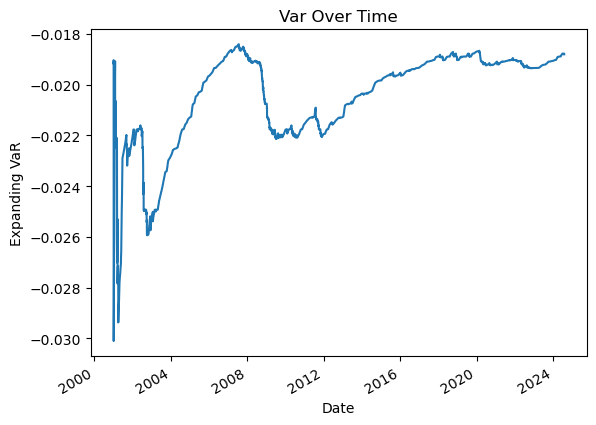

In [70]:
df['VaR'].plot(kind='line', title='Var Over Time')

plt.xlabel('Date')
plt.ylabel('Expanding VaR')
plt.show()

In [71]:
VaRcount = (df['Excess Returns'] <= df['VaR']).sum()
print("Expected returns exceed the VaR threshold {} times".format(VaRcount))

Expected returns exceed the VaR threshold 236 times


In [72]:
quantile_5th = df['Excess Returns'].quantile(0.05)
quantile_5th_count = (df['Excess Returns'] <= quantile_5th).sum()
print("Expected returns exceed the 5th Quantile threshold {} times".format(quantile_5th_count))

Expected returns exceed the 5th Quantile threshold 297 times


In this case, using historic VaR sets a VaR with not strict enough boundaries. Looking at the total data set, we exceeded the .05 quantile 297 times. However, with our historic VaR calculation we only got flagged doing this 236 times. Therefore, a more robust way to set the boundaries is needed.

1.2 Volatility

In [73]:
df['vol'] = df['Excess Returns'].std()
df['expanding vol'] = df['Excess Returns'].expanding().std()
df['rolling vol'] = df['Excess Returns'].rolling(window=30).std()

theta = 0.94
initial_vol = .2/np.sqrt(252)
ewma_vol = np.zeros(len(df['Excess Returns']))
ewma_vol[0] = initial_vol**2

for t in range(1,len(df['Excess Returns'])):
    ewma_vol[t] = theta * ewma_vol[t-1] + (1 - theta) * df['Excess Returns'].iloc[t-1]**2

ewma_vol =np.sqrt(ewma_vol)
df['ewma vol'] = ewma_vol

df.head()

,SPY,^IRX,Excess Returns,VaR,vol,expanding vol,rolling vol,ewma vol
date,,,,,,,,
2000-12-29,-0.018929,0.000227,-0.019157,-0.019157,0.012142,NaN,NaN,0.012599
2001-01-02,-0.018104,0.000225,-0.018329,-0.019115,0.012142,0.000585,NaN,0.013085
2001-01-03,0.048035,0.000219,0.047815,-0.019074,0.012142,0.038430,NaN,0.013458
2001-01-04,-0.010764,0.000208,-0.010972,-0.019033,0.012142,0.032195,NaN,0.017533
2001-01-05,-0.032643,0.000197,-0.032840,-0.030103,0.012142,0.031480,NaN,0.017210


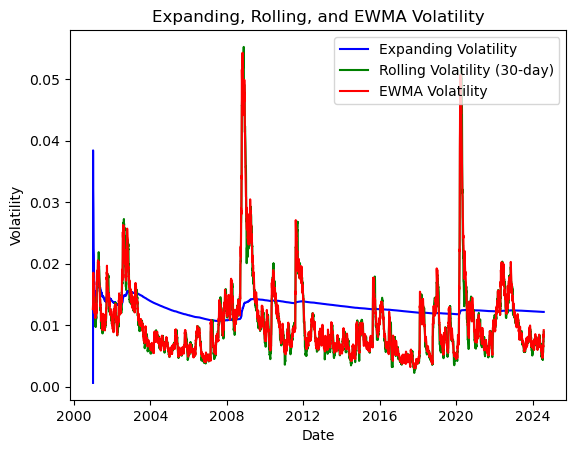

In [74]:
plt.plot(df.index, df['expanding vol'], label='Expanding Volatility', color='blue')
plt.plot(df.index, df['rolling vol'], label='Rolling Volatility (30-day)', color='green')
plt.plot(df.index, df['ewma vol'], label='EWMA Volatility', color='red')

plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Expanding, Rolling, and EWMA Volatility')

plt.legend()

plt.show()

In [75]:
df['VaR expanding'] = -1.65 * df['expanding vol']
df['VaR rolling'] = -1.65 * df['rolling vol']
df['VaR ewma'] = -1.65 * df['ewma vol']

df.head()

,SPY,^IRX,Excess Returns,VaR,vol,expanding vol,rolling vol,ewma vol,VaR expanding,VaR rolling,VaR ewma
date,,,,,,,,,,,
2000-12-29,-0.018929,0.000227,-0.019157,-0.019157,0.012142,NaN,NaN,0.012599,NaN,NaN,-0.020788
2001-01-02,-0.018104,0.000225,-0.018329,-0.019115,0.012142,0.000585,NaN,0.013085,-0.000965,NaN,-0.021591
2001-01-03,0.048035,0.000219,0.047815,-0.019074,0.012142,0.038430,NaN,0.013458,-0.063409,NaN,-0.022205
2001-01-04,-0.010764,0.000208,-0.010972,-0.019033,0.012142,0.032195,NaN,0.017533,-0.053122,NaN,-0.028930
2001-01-05,-0.032643,0.000197,-0.032840,-0.030103,0.012142,0.031480,NaN,0.017210,-0.051942,NaN,-0.028397


In [76]:
expandingCnt = (df['Excess Returns'] <= df['VaR expanding']).sum()
rollingCnt = (df['Excess Returns'] <= df['VaR rolling']).sum()
ewmaCnt = (df['Excess Returns'] <= df['VaR ewma']).sum()

print('The times returns exceed VaR for expanding, rolling, and EWMA methods are as follows: {}, {}, and {}.'.format(expandingCnt,rollingCnt,ewmaCnt))

The times returns exceed VaR for expanding, rolling, and EWMA methods are as follows: 218, 346, and 355.


It seems that the techniques from expanding, rolling, to ewma continuously become more conservative. Rolling and EWMA were also more conservative than our original method. Therefore, using EWMA seems to be the most risk averse technique.

1.3) CVaR

In [77]:
import scipy.stats as stats

alpha = .05


def calc_Cvar(volatility):
    z_alpha = stats.norm.ppf(alpha)
    cvar = -volatility * (stats.norm.pdf(z_alpha) / alpha)
    return cvar

df['CVaR'] = df['vol'].apply(calc_Cvar)
df['CVaR Expanding'] = df['expanding vol'].apply(calc_Cvar)
df['CVaR Rolling'] = df['rolling vol'].apply(calc_Cvar)
df['CVaR EWMA'] = df['ewma vol'].apply(calc_Cvar)

df.head()


,SPY,^IRX,Excess Returns,VaR,vol,expanding vol,rolling vol,ewma vol,VaR expanding,VaR rolling,VaR ewma,CVaR,CVaR Expanding,CVaR Rolling,CVaR EWMA
date,,,,,,,,,,,,,,,
2000-12-29,-0.018929,0.000227,-0.019157,-0.019157,0.012142,NaN,NaN,0.012599,NaN,NaN,-0.020788,-0.025044,NaN,NaN,-0.025988
2001-01-02,-0.018104,0.000225,-0.018329,-0.019115,0.012142,0.000585,NaN,0.013085,-0.000965,NaN,-0.021591,-0.025044,-0.001207,NaN,-0.026991
2001-01-03,0.048035,0.000219,0.047815,-0.019074,0.012142,0.038430,NaN,0.013458,-0.063409,NaN,-0.022205,-0.025044,-0.079270,NaN,-0.027759
2001-01-04,-0.010764,0.000208,-0.010972,-0.019033,0.012142,0.032195,NaN,0.017533,-0.053122,NaN,-0.028930,-0.025044,-0.066409,NaN,-0.036167
2001-01-05,-0.032643,0.000197,-0.032840,-0.030103,0.012142,0.031480,NaN,0.017210,-0.051942,NaN,-0.028397,-0.025044,-0.064934,NaN,-0.035500


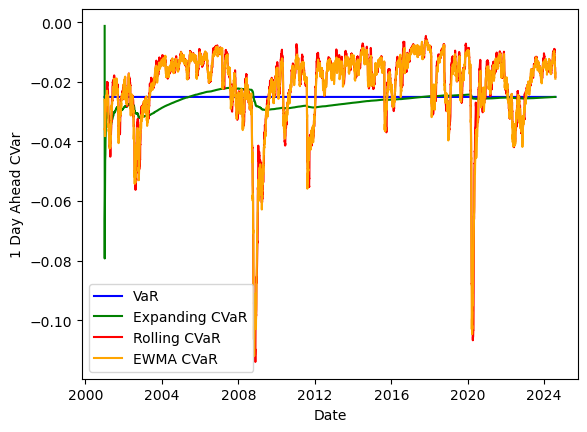

In [78]:
plt.plot(df.index, df['CVaR'], label='VaR', color='blue')
plt.plot(df.index, df['CVaR Expanding'], label='Expanding CVaR', color='green')
plt.plot(df.index, df['CVaR Rolling'], label='Rolling CVaR', color='red')
plt.plot(df.index, df['CVaR EWMA'], label='EWMA CVaR', color='orange')

plt.xlabel("Date")
plt.ylabel("1 Day Ahead CVar")
plt.legend()

plt.show()

This shows that Rolling and EWMA CVaR are far more conservative when addressing Expected Shortfall.